# Finding causal genotype-phenotype relations with ddlite: learning

## Introduction
In this example **ddlite** app, we'll build a system to indentify causal relationships between genotypes and phenotypes from raw journal articles. For the extraction stage, see **GenePhenRelationExample_Extraction.ipynb**.

In [1]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook. We can construct a `Relations` object with the file. We'll extract features and pickle them to save time in the future.

In [2]:
pkl_feats = 'gene_phen_relation_example/gene_phen_saved_feats_v2.pkl'
pkl_rel = 'gene_phen_relation_example/gene_phen_saved_relations_v2.pkl'
try:
    with open(pkl_feats, 'rb') as f:
        R = cPickle.load(f)
except:
    R = Relations(pkl_rel)
    %time R.extract_features()
    with open(pkl_feats, 'w+') as f:
        cPickle.dump(R, f)

## `CandidateModel` objects and feature generation
We'll then create a `CandidateModel` object for our extracted gene candidates. Features are automatically generated by `Relations`.

In [3]:
CM = CandidateModel(R)
print "Extracted {} features for each of {} mentions".format(CM.num_feats(), CM.num_candidates())

Extracted 89097 features for each of 4185 mentions


In [4]:
print "Feature sparsity: {:.5f}".format(float(CM.feats.nnz) / np.product(CM.feats.shape))

Feature sparsity: 0.00090


## Building a ground truth set
We'll load some "gold standard" labels which were generated from a previous MindTagger session. 

In [5]:
with open('gene_phen_relation_example/medium_simple_holdout.pkl', 'rb') as f:
    CM.set_gold_labels(cPickle.load(f))
CM.set_holdout()

## Writing labeling functions
We'll use the **data programming method** to learn a logistic regression model which will predict the probability of a candidate entity being a true causal relationship. We'll start by writing labeling functions, or LFs. These are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example).

In [6]:
from GenePhenLFs import lfs

In [7]:
CM.apply_lfs(lfs, clear=True)

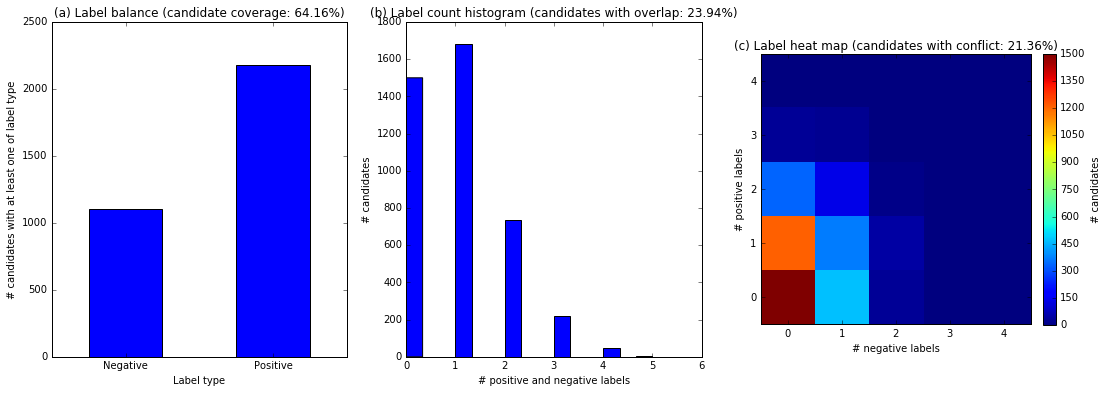

In [8]:
CM.plot_lf_stats()

In [9]:
CM.top_conflict_lfs(n=5)

Labeling function,Fraction of candidates where LF has conflict
lf_long,0.095
lf_all,0.039
lf_p_8,0.038
lf_p_7,0.033
lf_mutation,0.032


In [10]:
CM.lowest_coverage_lfs(n=5)

Labeling function,Fraction of abstained votes
lf_p_4,1.000
lf_express,0.997
lf_loss,0.997
lf_deletion,0.997
lf_p_2,0.991


In [11]:
CM.lowest_empirical_accuracy_lfs(n=10)

Labeling function,Empirical LF accuracy
lf_p_4,0.000 (n=0)
lf_p_6,0.000 (n=2)
lf_p_5,0.400 (n=10)
lf_p_8,0.429 (n=14)
lf_p_7,0.429 (n=21)
lf_aut,0.556 (n=9)
lf_long,0.558 (n=43)
lf_p_1,0.661 (n=124)
lf_p_3,0.721 (n=68)
lf_short,0.733 (n=15)


## Learning

Running test fold 0


../ddlite.py:1005: UserWarning: SGD did not converge for mu=0.000. Try increasing maxIter.
  warnings.warn("SGD did not converge for mu={:.3f}. Try increasing maxIter.".format(mu))


Running test fold 1
Running test fold 2


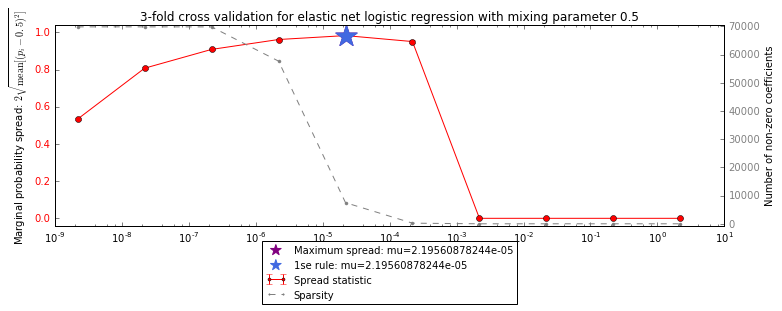

CPU times: user 11min 18s, sys: 472 ms, total: 11min 18s
Wall time: 11min 37s


<ddlite.ModelLog instance at 0x7f5307f9f7a0>

In [12]:
matplotlib.rcParams['figure.figsize'] = (12,4)
%time CM.learn_weights(tol=1e-3, sample=True, maxIter=2500, n_mu=10, mu_min_ratio=1e-9, alpha=0.5, verbose=True, plot=True, log=True)

/home/henry/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/henry/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


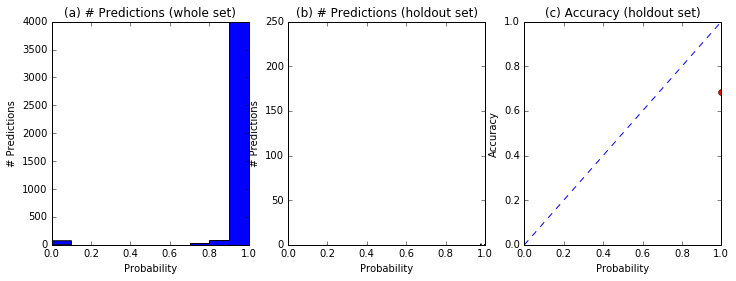

In [13]:
CM.plot_calibration()

In [14]:
print "Number of non-zero weights: {}".format(np.sum(np.abs(CM.w) > 1e-12))

Number of non-zero weights: 7735
